In [114]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from datetime import datetime
from scipy.stats.mstats import winsorize

In [115]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [116]:
# process score
cols = ['Time', 'EtfPrice']
score = pd.read_csv('../score_board.csv')
score = score[cols]

# process log
trader_info = '[INFO   ] [TRADER]'
log = []
with open('../retard.log', 'r') as f:
    for line in f:
        if trader_info in line:
            x = '(' + line.split(trader_info)[-1].strip('\n').strip() + ')'
            x = eval(x)
            log.append(x)
log = pd.DataFrame(log, columns=['Time', 'TradedBid', 'TradedAsk'])
scaler = MinMaxScaler(feature_range=(score.Time.min(), score.Time.max()))
log['Time'] = scaler.fit_transform(log.Time.values.reshape(-1, 1)).flatten()

In [151]:
d = {}
for b in [.01, .05, .1, .25, .4, .5]:
    d[b] = (data[data.Signal < b]['FutureEtfRet'].mean(), data[data.Signal > 1-b]['FutureEtfRet'].mean())
d = pd.DataFrame.from_dict(d, orient='index')

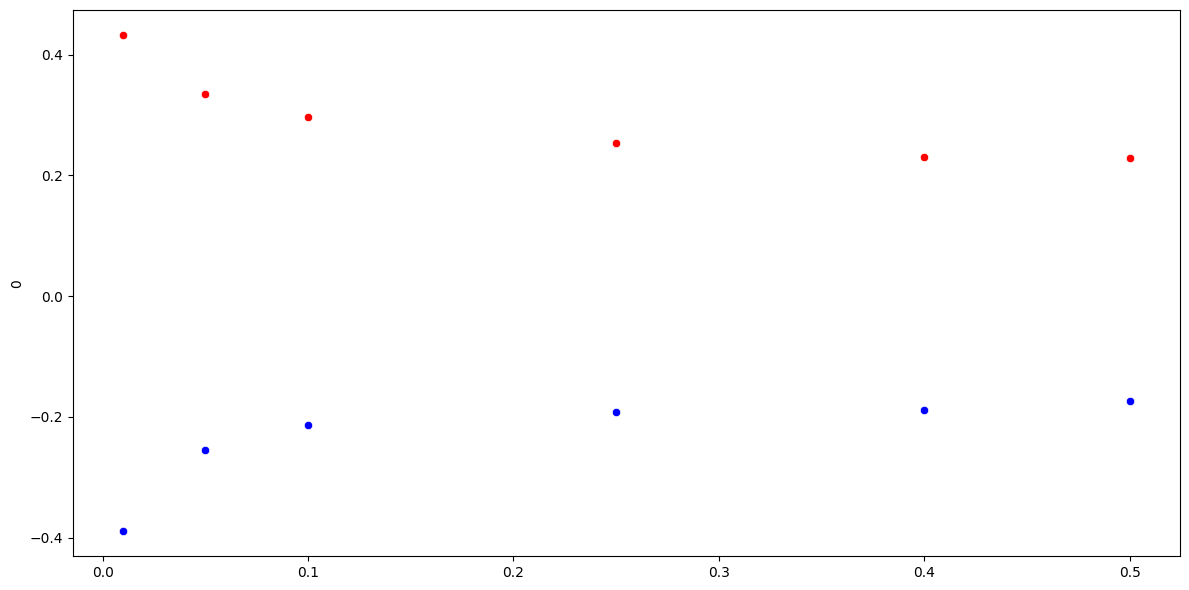

In [154]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.scatterplot(x=d.index, y=0, data=d, ax=ax, c='r')
sns.scatterplot(x=d.index, y=1, data=d, ax=ax, c='b')
plt.tight_layout()
plt.show()

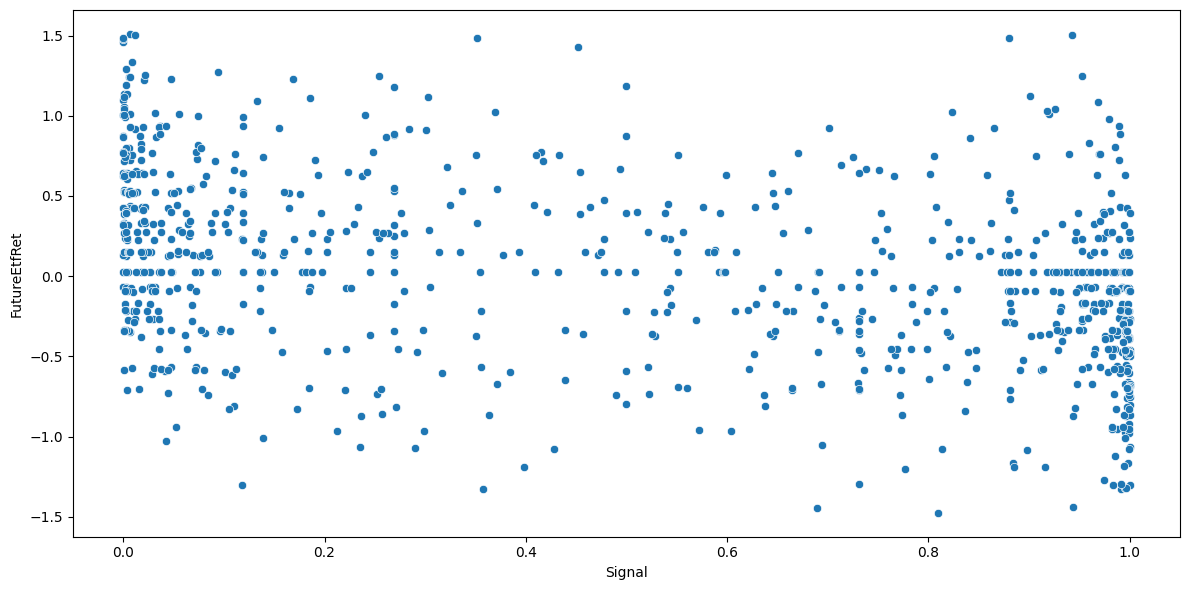

In [132]:
### PROCESSING SCOREBOARD FOR PREDICTION
temp_score = score[(score.EtfPrice.notna())].copy()

temp_score['Time'] = temp_score.Time.shift(1)
temp_score['FutureEtfRet'] = np.log(temp_score.EtfPrice) - np.log(temp_score.EtfPrice.shift(1))
temp_score = temp_score.iloc[1:][['Time', 'FutureEtfRet']]

temp_score['Time'] = temp_score.Time // 1 + 1

NSEC = 4
bottom, top = temp_score.Time.min(), temp_score.Time.max()
l = np.arange(bottom, top, NSEC)
df = []
for i in range(len(l)-1):
    s = temp_score[(temp_score.Time >= l[i]) & (temp_score.Time < l[i+1])]
    if len(s) >= 1:
        df.append((l[i+1], s.FutureEtfRet.sum()))
    s = None

df = pd.DataFrame(df, columns=['Time', 'FutureEtfRet'])
df['FutureEtfRet'] = (df.FutureEtfRet - df.FutureEtfRet.mean()) / df.FutureEtfRet.std()

### PROCESSING LOG FOR PREDICTION
temp_log = log.copy()
temp_log['Time'] = temp_log.Time // 1 + 1

l = np.arange(bottom, top, NSEC)
df2 = []
for i in range(len(l)-1):
    s = temp_log[(temp_log.Time >= l[i]) & (temp_log.Time < l[i+1])]
    if len(s) >= 1:
        bids, asks = s.TradedBid.sum(), s.TradedAsk.sum()
        atv = (bids+asks)/len(s)
        sig = (bids-asks)/atv
        df2.append((l[i+1], sigmoid(sig)))
df2 = pd.DataFrame(df2, columns=['Time', 'Signal'])

### MERGE DATA
data = df.merge(df2, on='Time', how='inner')

### TRIM OUTLIER RETURNS
a = 0.01
lb, ub = np.quantile(data.FutureEtfRet, [a, 1-a])
data = data[(data.FutureEtfRet >= lb) & (data.FutureEtfRet <= ub)]

### PLOT
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

sns.scatterplot(x=data['Signal'], y=data['FutureEtfRet'], ax=ax)

plt.tight_layout()
plt.show()